Alumnos:

- Fabian Nova
- Effry Vigorena
- Wilder Prado
- Felipe Guzmán

In [1]:
# Importando librerias
import pandas as pd
import numpy as np
import sweetviz as sv
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot  as plt
import seaborn as sns
import networkx as nx


In [87]:
## Funciones para procesar datos
'''
Funcion que permite cambiar datos de textos
'''
def cambiando_datos_texto(df_, columns_):
        cat_numeric = LabelEncoder()
        return pd.DataFrame(cat_numeric.fit_transform(df_[[columns_]]))
    
# 
def get_community_matrix(A, com):
    n = len(A)
    
    # número de comunidades
    nc = len(set(com))

    # Inicializar lista de matrices de adyacencia
    e = np.zeros((nc, nc))

    # Crea enlace y normaliza valores dividiendo por la suma de todos los enlaces (dependiente del tamaño de la red)
    m = 0
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                ic = com[i]
                jc = com[j]
                if ic == jc:
                    e[ic,ic] += A[i, j]
                else:
                    e[ic,jc] += 0.5*A[i,j]
                    e[jc,ic] = e[ic,jc]
                m += A[i,j]
    return e/m


def fast_greedy(G):
    import heapq

    L = G.size()
    #L = len(G.edges())
    for u, v in G.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        G[u][v]['weight']=1.0/(2.0*L)
    for u in G:
        G.nodes[u]['weight'] = G.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(G, {node:frozenset((node,)) for node in G}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(G.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q


In [3]:
dataset  = './lic2020_hackaton.csv'

In [4]:

df_read = pd.read_csv(dataset, encoding='ISO-8859-1', delimiter=',', engine='python')


In [5]:
## Crear una copia del dataframe
df_copy = df_read.copy()

In [6]:
# report_sv = sv.analyze(df_read)
# report_sv.show_html(filepath='reporte_sv.html')

In [7]:
#Seleccion rapida de datos
# - Codigo
# - Tipo de Adquisicion
# - Estado,
# - CodigoOrganismo
# - NombreOrganismo
# - FechaPublicacion (? Queda fuera debido a que no tenemos la fecha de adjudicacion para identificar los tiempos de duracion de la licitación)
# - RutProveedor
# - NombreProveedor (? vacios)
# - Moneda de la Oferta
# - MontoLineaAdjudica
# - Ofertaseleccionada

In [8]:
df_read.head(5)

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
0,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,76.432.529-K,CSL Behring SpA Chile,Peso Chileno,0,No Seleccionada
1,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.945.670-2,NOVOFARMA SERVICE - LABORATORIO BAGO,Peso Chileno,0,No Seleccionada
2,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,1592000,Seleccionada
3,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.859.930-5,Libra Chile S.A.,Peso Chileno,0,No Seleccionada
4,8468777,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1375151,HOSPITAL CLINICO METROPOLITANO LA FLORIDA DRA ...,65.075.485-9,NaN,2020-01-21,51201806,96.582.310-7,Grifols Chile S.A.,Peso Chileno,19320600,Seleccionada


In [9]:
# 1. Descripción de los datos
    # Identificar tipos -> OK
    # Identificar Nulos -> OK
    # Distribución de los datos -
# Correlación

In [10]:

columnas = df_read.dtypes.reset_index().rename(columns={'index':'columna', 0:'tipo'})
campos_nulos = df_read.columns[df_read.isnull().sum() > 0].to_list()
campos_numericos =columnas[columnas.tipo!='object']['columna'].to_list()
campos_textos = columnas[columnas.tipo=='object']['columna'].to_list()

print("Campos nulos:", campos_nulos)
print("Campos numericos:", campos_numericos)
print("Campos textos:", campos_textos)

Campos nulos: ['ComunaUnidad', 'NombreProveedor']
Campos numericos: ['Codigo', 'CodigoOrganismo', 'CodigoProductoONU']
Campos textos: ['Tipo de Adquisicion', 'Estado', 'NombreOrganismo', 'RutUnidad', 'ComunaUnidad', 'FechaPublicacion', 'RutProveedor', 'NombreProveedor', 'Moneda de la Oferta', 'MontoLineaAdjudica', 'Oferta seleccionada']


In [11]:
# De  los campos numericos
df_read.describe()

,Codigo,CodigoOrganismo,CodigoProductoONU
count,1.882980e+06,1.882980e+06,1.882980e+06
mean,8.695127e+06,1.168506e+05,4.667639e+07
std,3.780515e+04,2.768295e+05,1.704853e+07
min,8.468777e+06,6.918000e+03,1.010150e+07
25%,8.663760e+06,7.321000e+03,4.111312e+07
50%,8.693322e+06,8.656800e+04,4.410310e+07
75%,8.724727e+06,1.150090e+05,5.117190e+07
max,8.886994e+06,1.741046e+06,1.041010e+08


In [12]:
df_read['Tipo de Adquisicion'].unique()

array(['Licitación Pública entre a 2000 y 5000 UTM (LQ)',
       'Licitación Pública Entre 100 y 1000 UTM (LE)',
       'Licitación Pública Mayor 1000 UTM (LP)',
       'Licitación Pública Mayor a 5000 (LR)',
       'Licitación Pública Menor a 100 UTM (L1)',
       'Licitación Pública MOP (O1)',
       'Licitación Pública Servicios personales especializados (LS)',
       'Licitación Privada entre 100 y 1000 UTM.',
       'Licitación Privada Mayor a 1000 UTM',
       'Licitación Privada entre a 2000 y 5000 UTM (H2)',
       'Licitación Privada Menor a 100 UTM.',
       'Licitación Privada Mayor a 5000 (I2)',
       'Licitación Privada MOP (O2)'], dtype=object)

In [13]:
df_read['Estado'].unique()

array(['Adjudicada', 'Desierta (o art. 3 ó 9 Ley 19.886)', 'Cerrada',
       'Revocada', 'Suspendida'], dtype=object)

In [14]:
df_read['Moneda de la Oferta'].unique()

array(['Peso Chileno', 'Moneda revisar', 'Unidad de Fomento', 'Dolar',
       'Euro'], dtype=object)

In [15]:
df_read['Oferta seleccionada'].unique()

array(['No Seleccionada', 'Seleccionada'], dtype=object)

In [16]:
## checkear
# df_read[~df_read['MontoLineaAdjudica'].str.isnumeric()]
df_copy['monto_numeric'] = pd.to_numeric(df_copy['MontoLineaAdjudica'], errors='coerce')
non_numeric_values = df_copy[pd.isnull(df_copy['monto_numeric'])]['monto_numeric']

In [17]:
cat_features = ['Tipo de Adquisicion', 'Estado', 'Moneda de la Oferta', 'Oferta seleccionada']


In [19]:
for i in cat_features:
    df_copy[i]=cambiando_datos_texto(df_=df_copy, columns_=i) 

/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-v

In [20]:
df_copy['rut_numeric'] = df_copy['RutProveedor'].map(lambda x: str(x).replace('.',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('-',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('k','0'))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('K','0'))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('FR',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('A',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('B',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace(' ',''))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('SINDT','0'))
df_copy['rut_numeric'] = df_copy['rut_numeric'].map(lambda x: str(x).replace('ES',''))
df_copy[~df_copy['rut_numeric'].str.isnumeric()]
df_copy['rut_numeric'] = df_copy['rut_numeric'].astype('int')


In [21]:
df_copy.corr()

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,CodigoProductoONU,Moneda de la Oferta,Oferta seleccionada,monto_numeric,rut_numeric
Codigo,1.000000,-0.025301,-0.002609,0.002972,0.022062,-0.015748,-0.001475,0.000682,0.028195
Tipo de Adquisicion,-0.025301,1.000000,0.014196,-0.014372,-0.037465,0.000604,0.010862,0.000233,-0.010150
Estado,-0.002609,0.014196,1.000000,-0.007591,0.019904,-0.006641,-0.133981,-0.000224,-0.022225
CodigoOrganismo,0.002972,-0.014372,-0.007591,1.000000,0.026040,0.006680,0.007843,-0.000085,0.008462
CodigoProductoONU,0.022062,-0.037465,0.019904,0.026040,1.000000,0.030431,0.038867,0.001456,-0.031864
Moneda de la Oferta,-0.015748,0.000604,-0.006641,0.006680,0.030431,1.000000,-0.004511,0.000036,-0.012808
Oferta seleccionada,-0.001475,0.010862,-0.133981,0.007843,0.038867,-0.004511,1.000000,0.001680,-0.010406
monto_numeric,0.000682,0.000233,-0.000224,-0.000085,0.001456,0.000036,0.001680,1.000000,0.000143
rut_numeric,0.028195,-0.010150,-0.022225,0.008462,-0.031864,-0.012808,-0.010406,0.000143,1.000000


/tmp/ipykernel_50756/22769716.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df_copy.corr(), dtype=np.bool))


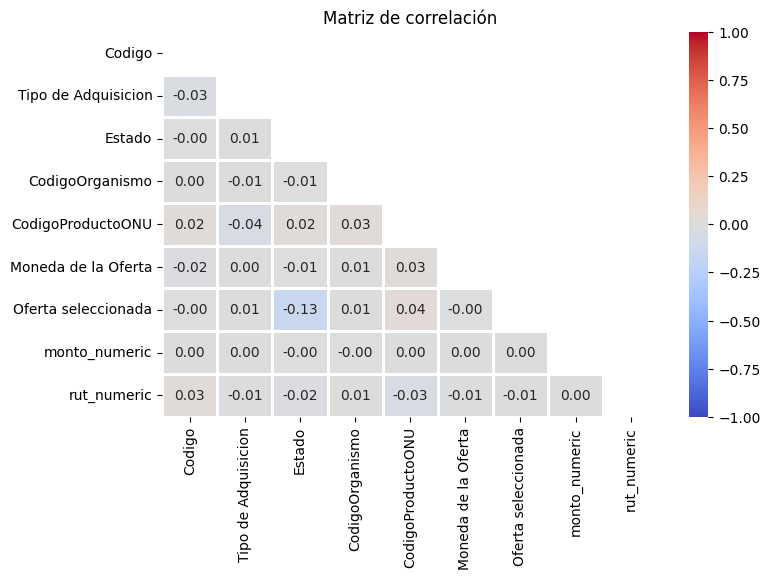

In [22]:
## Matriz de correlacion 
plt.figure(figsize = (8,5))
plt.title('Matriz de correlación')

mask = np.triu(np.ones_like(df_copy.corr(), dtype=np.bool))
sns.heatmap(df_copy.corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="coolwarm") 
plt.show()


In [23]:
df_copy.dtypes[df_copy.dtypes=='int64'].index.to_list()

['Codigo',
 'Tipo de Adquisicion',
 'Estado',
 'CodigoOrganismo',
 'CodigoProductoONU',
 'Moneda de la Oferta',
 'Oferta seleccionada',
 'rut_numeric']

/home/fguzman/miniconda3/envs/mdd/lib/python3.10/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


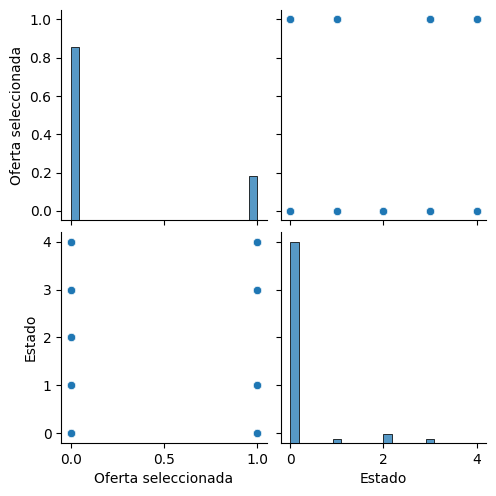

In [24]:
# Se revisa cual es la distribución de las variables numéricas
# sns.set()
cols =['Oferta seleccionada','Estado']
sns.pairplot(df_copy[cols], size = 2.5)

# plt.show()

## Resumen de Analisis exploratorio

- Se observa que los datos solo existen dos campos cuyo valor son nulos (ComunaUnidad, NombreProveedor)
- Existen 3 columnas numericas (Codigo, CodigoOrganismo, CodigoProductoOnu)
- Existen 11 columnas de tipo texto ('Tipo de Adquisicion', 'Estado', 'NombreOrganismo', 'RutUnidad', 'ComunaUnidad', 'FechaPublicacion', 'RutProveedor', 'NombreProveedor', 'Moneda de la Oferta', 'MontoLineaAdjudica', 'Oferta seleccionada')
- los datos de texto más relevantes para el analisis son:
  - ['Tipo de Adquisicion', 'Estado', 'Moneda de la Oferta', 'Oferta seleccionada', 'RutProveedor]
- Se aplican conversiones (encoder) para los datos de texto relevantes para identificar si existe correlacion
- No se aprecia una correlación entre los datos (correlación baja)
- Al comparar la distribución de los datos entre las variables de estado y oferta seleccionada no se aprecia ningun tipo de distribución

## Hipotesis
  ### La cantidad de oferentes que se presentan en unitario a una licitación representan una caracteristica que puede ser un patrón potencial de corrupción 

In [25]:
df_copy = df_read.copy()

In [7]:
# Agrupamos las licitaciones por codigo de licitacion y contamos los oferentes que se participaron
df_empresas_x_licitacion = df_copy[['Codigo','RutProveedor']].groupby(by=['Codigo']).size().reset_index().rename(columns={0:'Cantidad_oferentes'})

In [8]:
df_empresas_x_licitacion.sort_values(by='Cantidad_oferentes', ascending=False)

,Codigo,Cantidad_oferentes
1920,8636096,4792
59412,8715117,3012
746,8632917,2780
8837,8646101,2499
18699,8659604,2401
...,...,...
5703,8641679,1
58340,8713692,1
14788,8654339,1
58355,8713710,1


In [28]:
## Seleccionamos las licitaciones en donde solo participa 1 oferente
datos_a_ocupar = df_empresas_x_licitacion[df_empresas_x_licitacion.Cantidad_oferentes==1]
codigos_licitaciones = datos_a_ocupar.Codigo.to_list()

In [29]:
df_solo_1_empresa = df_copy[df_copy.Codigo.isin(codigos_licitaciones)]

In [30]:
df_solo_1_empresa

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada
39,8531486,Licitación Pública Mayor 1000 UTM (LP),Adjudicada,7045,SERVICIO DE SALUD NORTE HOSPITAL ROBERTO DEL RIO,61.608.004-0,Independencia,2020-01-14,42295303,76.018.213-3,ADVANCED MEDICAL PRODUCTS SPA,Peso Chileno,110000,Seleccionada
1111,8578778,Licitación Pública Mayor a 5000 (LR),Adjudicada,7474,Instituto de Neurocirugía,61.608.407-0,Providencia,2020-01-02,72131702,11.844.310-1,PAMELA NATHALIE ROJAS DONOSO,Peso Chileno,400674996,Seleccionada
1190,8590377,Licitación Pública Mayor 1000 UTM (LP),Adjudicada,1667479,SERVICIO DE SALUD ARICA HOSP DR JUAN NOE CREVANI,61.606.001-5,Santiago,2020-01-27,73152101,76.885.254-5,Milca Sarai,Peso Chileno,55507680,Seleccionada
1195,8593093,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,1667479,SERVICIO DE SALUD ARICA HOSP DR JUAN NOE CREVANI,61.606.001-5,Arica,2020-01-27,51142941,77.478.120-k,Fresenius Kabi Chile Ltda.,Peso Chileno,79128000,Seleccionada
1267,8595840,Licitación Pública Entre 100 y 1000 UTM (LE),Desierta (o art. 3 ó 9 Ley 19.886),87187,I MUNICIPALIDAD DE LOS ANGELES,69.170.101-8,Los Angeles,2020-01-17,72101603,76.723.997-1,Maxi Ingenieria Construcción,Peso Chileno,0,No Seleccionada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876637,8730978,Licitación Pública Menor a 100 UTM (L1),Adjudicada,7436,SERVICIO DE SALUD HOSPITAL DE PICHILEMU,61.602.153-2,Santiago,2020-09-30,30201902,76.098.322-5,VitroScience LTDA,Peso Chileno,812040,Seleccionada
1876638,8730981,Licitación Pública Menor a 100 UTM (L1),Desierta (o art. 3 ó 9 Ley 19.886),7436,SERVICIO DE SALUD HOSPITAL DE PICHILEMU,61.602.153-2,Santiago,2020-09-30,30201902,79.568.850-1,VALTEK S.A.,Peso Chileno,0,No Seleccionada
1876682,8730986,Licitación Pública Menor a 100 UTM (L1),Adjudicada,98443,I MUNICIPALIDAD DE TOME,69.150.100-0,Tomé,2020-09-30,11111611,76.722.635-7,MOSIL LIMITADA,Peso Chileno,797643,Seleccionada
1876683,8730987,Licitación Pública Menor a 100 UTM (L1),Adjudicada,7436,SERVICIO DE SALUD HOSPITAL DE PICHILEMU,61.602.153-2,Santiago,2020-09-30,72101607,13.636.560-6,LARRY ENZO,Peso Chileno,1800000,Seleccionada


In [ ]:
# report_sv = sv.analyze(df_solo_1_empresa)
# report_sv.show_html(filepath='reporte_solo1_empresa.html')

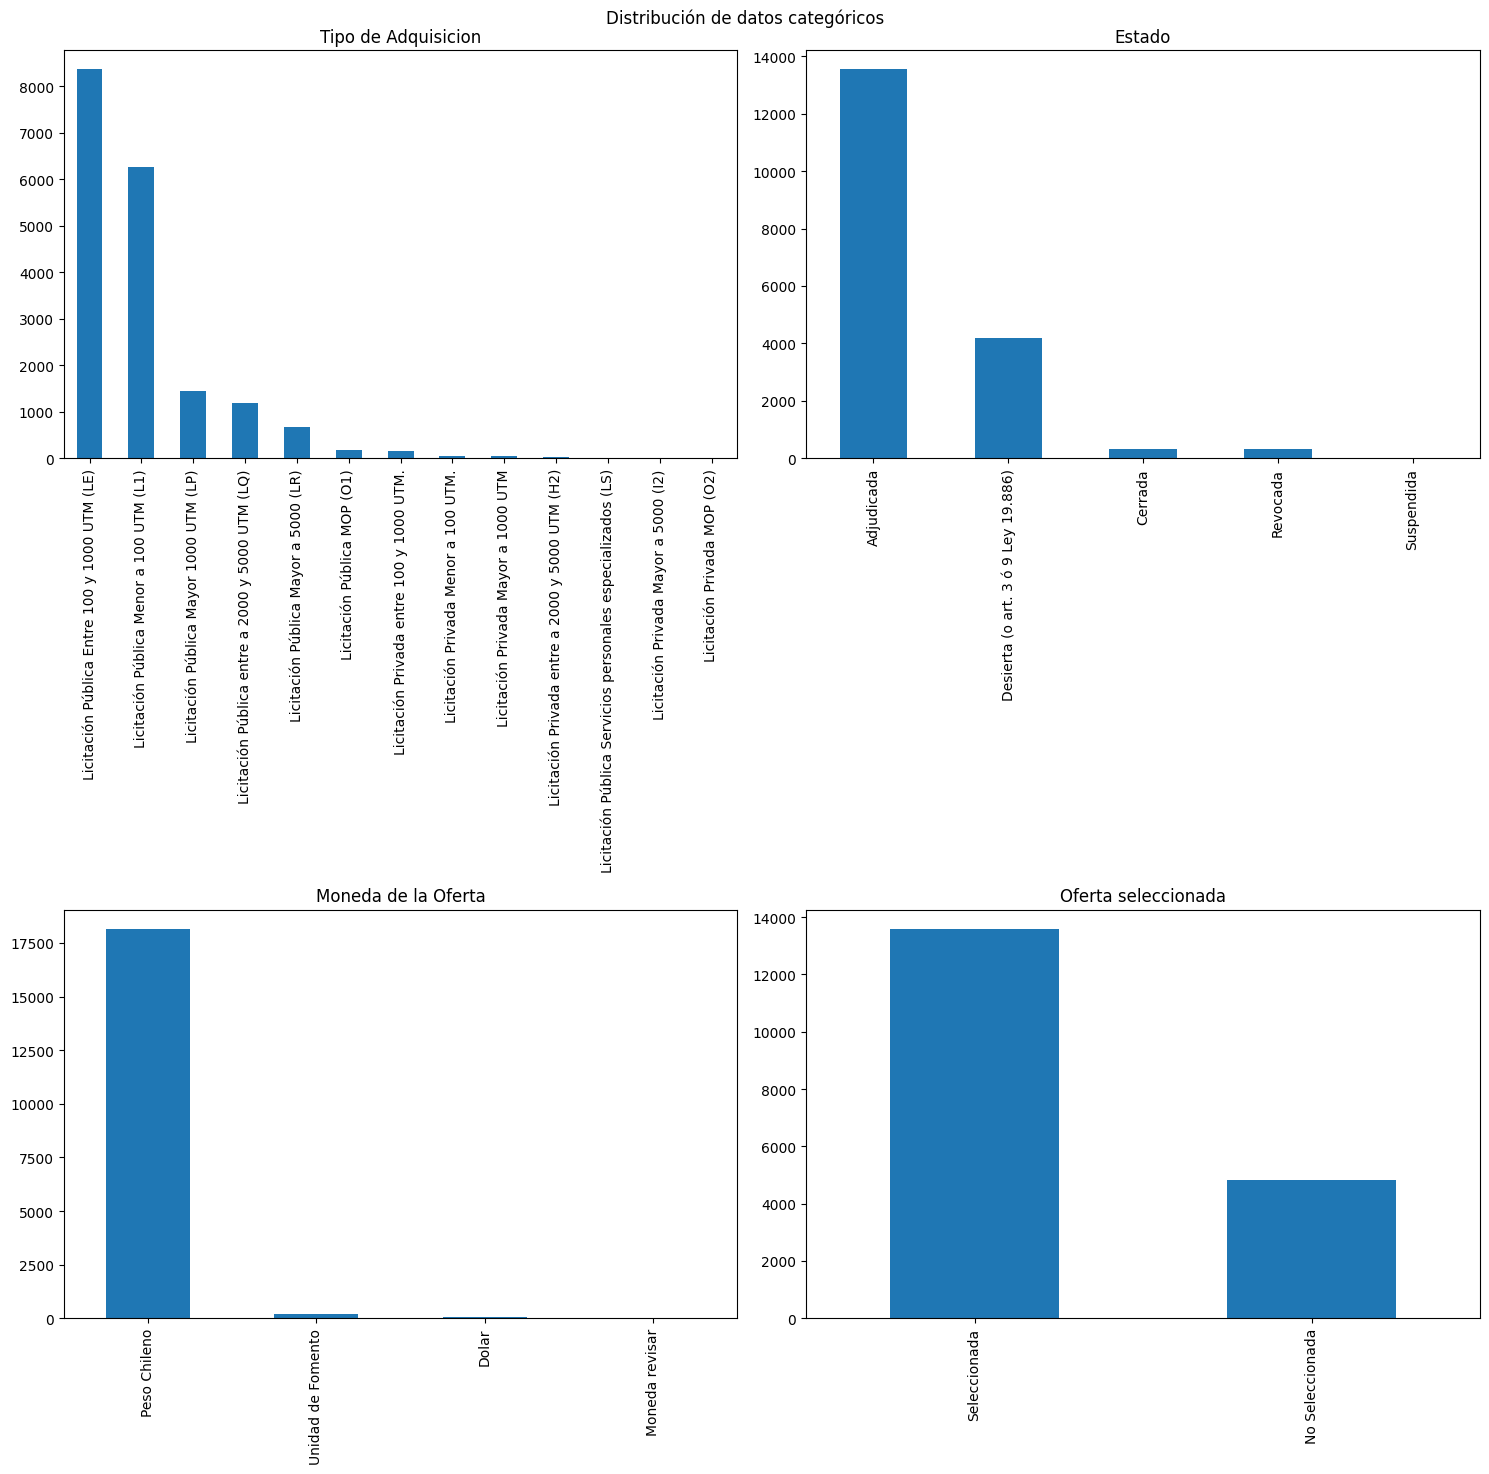

In [31]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
plt.suptitle('Distribución de datos categóricos')
for c,i in enumerate(cat_features):
    if c < 2:       
        df_solo_1_empresa[i].value_counts().plot(kind='bar', ax=axes[0,c]).set_title(i)
    else:
        df_solo_1_empresa[i].value_counts().plot(kind='bar', ax=axes[1,c-2]).set_title(i)
    
    
plt.tight_layout()
plt.show()
    

## Generación de la red

In [9]:
df_copy.Estado.unique()

array(['Adjudicada', 'Desierta (o art. 3 ó 9 Ley 19.886)', 'Cerrada',
       'Revocada', 'Suspendida'], dtype=object)

## Con 3 oferentes

In [10]:
## Seleccionamos las licitaciones en donde solo participa 1 oferente
datos_a_ocupar_x_3 = df_empresas_x_licitacion[df_empresas_x_licitacion.Cantidad_oferentes<4]
codigos_licitaciones = datos_a_ocupar_x_3.Codigo.to_list()

In [11]:
df_solo_3_empresas = df_copy[df_copy.Codigo.isin(codigos_licitaciones)]

In [12]:
len(df_solo_3_empresas)

84806

In [13]:
df_solo_3_empresas.columns

Index(['Codigo', 'Tipo de Adquisicion', 'Estado', 'CodigoOrganismo',
       'NombreOrganismo', 'RutUnidad', 'ComunaUnidad', 'FechaPublicacion',
       'CodigoProductoONU', 'RutProveedor', 'NombreProveedor',
       'Moneda de la Oferta', 'MontoLineaAdjudica', 'Oferta seleccionada'],
      dtype='object')

In [14]:
df_solo_3_empresas['Estado_numeric']= df_solo_3_empresas[['Estado']].apply(LabelEncoder().fit_transform)

/tmp/ipykernel_13139/2961590047.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_solo_3_empresas['Estado_numeric']= df_solo_3_empresas[['Estado']].apply(LabelEncoder().fit_transform)


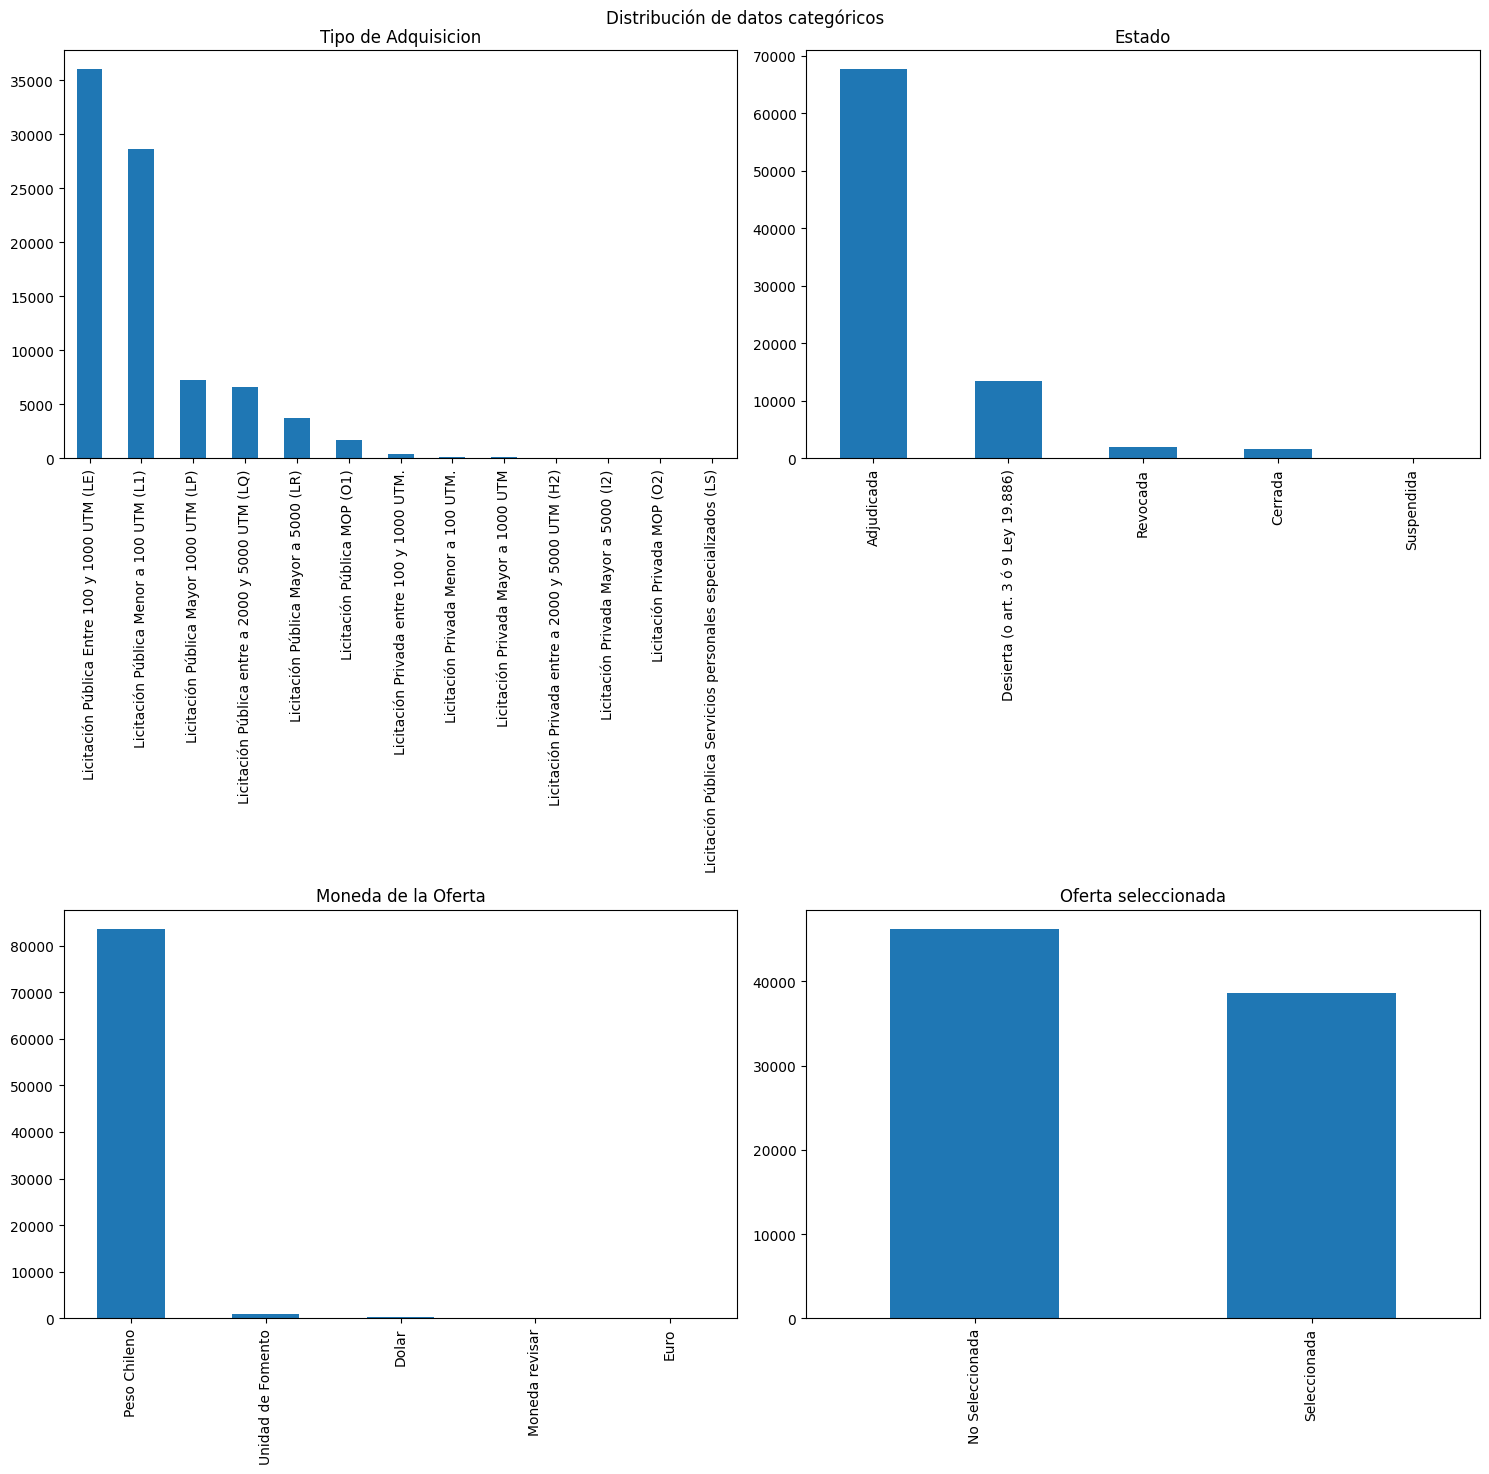

In [38]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
plt.suptitle('Distribución de datos categóricos')
for c,i in enumerate(cat_features):
    if c < 2:       
        df_solo_3_empresas[i].value_counts().plot(kind='bar', ax=axes[0,c]).set_title(i)
    else:
        df_solo_3_empresas[i].value_counts().plot(kind='bar', ax=axes[1,c-2]).set_title(i)
    
    
plt.tight_layout()
plt.show()

In [31]:
sample_data = 1000
df_solo_3_empresas_sample = df_solo_3_empresas[['Codigo','RutProveedor','Estado_numeric','Estado']].sample(sample_data)
df_solo_3_empresas_sample = df_solo_3_empresas_sample[columnas_red].sort_values(by=columnas_red).reset_index().drop(columns='index')

In [32]:
columnas_red = ['RutProveedor','Codigo','Estado_numeric']

In [33]:
G = nx.DiGraph() 
for row in df_solo_3_empresas_sample.index:
    G.add_edge(df_solo_3_empresas_sample['Codigo'][row],df_solo_3_empresas_sample['RutProveedor'][row]) #,weight=df_solo_3_empresas['Estado_numeric'][row]) 

In [34]:
print('Tamaño del dataframe', len(df_solo_3_empresas_sample))
print("Number of edges: ", G.number_of_edges())
print("Number of nodes: ", G.number_of_nodes()) 

Tamaño del dataframe 1000
Number of edges:  999
Number of nodes:  1850


In [22]:
len(df_solo_3_empresas['RutProveedor'].unique())

22288

In [46]:
len(df_solo_3_empresas['Codigo'].unique())

45904

In [38]:
df_solo_3_empresas_sample[df_solo_3_empresas_sample.Codigo == 8687740]

,RutProveedor,Codigo,Estado_numeric
552,76.688.898-4,8687740,0
788,78.292.110-k,8687740,0


In [ ]:
i=0
for c in C:
    i+=1
    print(f"Tamaño comunidad {i}: {len(c)}") 

In [ ]:
sample_data = 1000
df_solo_3_empresas_sample = df_solo_3_empresas[['Codigo','RutProveedor','Estado_numeric','Estado']].sample(sample_data)
df_solo_3_empresas_sample = df_solo_3_empresas_sample[columnas_red].sort_values(by=columnas_red).reset_index().drop(columns='index')

In [51]:
filter_2 = df_solo_3_empresas[['Estado','RutProveedor','CodigoOrganismo']].query('Estado == "Adjudicada"').groupby(['RutProveedor','CodigoOrganismo']).count().reset_index()

In [57]:
sample_data

1000

In [54]:
# filter_2.sample(sample_data)
df_test = filter_2.sample(sample_data).reset_index().drop(columns='index')
G = nx.DiGraph() 
for row in filter_2.index:
    G.add_edge(filter_2['RutProveedor'][row],filter_2['CodigoOrganismo'][row],weight=filter_2['Estado'][row]) 

In [65]:
'

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada,Estado_numeric
39,8531486,Licitación Pública Mayor 1000 UTM (LP),Adjudicada,7045,SERVICIO DE SALUD NORTE HOSPITAL ROBERTO DEL RIO,61.608.004-0,Independencia,2020-01-14,42295303,76.018.213-3,ADVANCED MEDICAL PRODUCTS SPA,Peso Chileno,110000,Seleccionada,0
40,8535174,Licitación Pública Mayor a 5000 (LR),Adjudicada,6935,PARQUE METROPOLITANO DE SANTIAGO,61.809.000-0,Recoleta,2020-01-10,70151805,96.816.640-9,NUCLEO PAISAJISMO S A,Peso Chileno,0,No Seleccionada,0
41,8535174,Licitación Pública Mayor a 5000 (LR),Adjudicada,6935,PARQUE METROPOLITANO DE SANTIAGO,61.809.000-0,Recoleta,2020-01-10,70151805,87.749.600-7,FRAY JORGE S.A.,Peso Chileno,0,No Seleccionada,0
42,8535174,Licitación Pública Mayor a 5000 (LR),Adjudicada,6935,PARQUE METROPOLITANO DE SANTIAGO,61.809.000-0,Recoleta,2020-01-10,70151805,79.640.110-9,Construcciones y Servicios Siglo Verde S.A.,Peso Chileno,1221565368,Seleccionada,0
60,8555911,Licitación Pública Entre 100 y 1000 UTM (LE),Adjudicada,99860,MUNICIPALIDAD DE OVALLE,69.040.700-0,Ovalle,2020-01-03,72131702,76.157.558-9,FAYC S.P.A.,Peso Chileno,0,No Seleccionada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881702,8761626,Licitación Pública Menor a 100 UTM (L1),Adjudicada,87187,I MUNICIPALIDAD DE LOS ANGELES,69.170.100-K,Los Angeles,2020-09-11,42121604,76.218.200-9,Dykonos Cía. Ltda.,Peso Chileno,0,No Seleccionada,0
1881703,8761626,Licitación Pública Menor a 100 UTM (L1),Adjudicada,87187,I MUNICIPALIDAD DE LOS ANGELES,69.170.100-K,Los Angeles,2020-09-11,42121604,88.270.200-6,Farmacia Veterinaria Lahuen Ltda,Peso Chileno,4150515,Seleccionada,0
1881738,8762724,Licitación Pública Entre 100 y 1000 UTM (LE),Adjudicada,6932,SERVICIO DE SALUD NUBLE,61.607.000-2,Chillán,2020-09-30,46171610,76.786.764-6,Tulaled Ltda,Peso Chileno,10737405,Seleccionada,0
1881739,8762724,Licitación Pública Entre 100 y 1000 UTM (LE),Adjudicada,6932,SERVICIO DE SALUD NUBLE,61.607.000-2,Chillán,2020-09-30,46171610,76.736.266-8,SMARTELEC SPA,Peso Chileno,0,No Seleccionada,0


In [73]:
df_solo_3_empresas.to_excel('salida.xlsx')

In [75]:
df_solo_3_empresas_1erFiltro = df_solo_3_empresas[(df_solo_3_empresas['Oferta seleccionada']=="Seleccionada") & (df_solo_3_empresas['Estado']=='Adjudicada')]
# Estado=="Adjudicada" and "Oferta seleccionada" =="Seleccionada"'

In [77]:
columnas_filter = ['CodigoOrganismo','RutProveedor','Estado']
df_solo_3_empresas_1erFiltro = df_solo_3_empresas_1erFiltro[columnas_filter].groupby(by=['CodigoOrganismo','RutProveedor']).count().reset_index().sort_values(by='Estado',ascending=False)

In [79]:
df_solo_3_empresas_1erFiltro = df_solo_3_empresas_1erFiltro[['CodigoOrganismo','RutProveedor','Estado']].query('Estado >10')

In [80]:
df_solo_3_empresas_1erFiltro

,CodigoOrganismo,RutProveedor,Estado
1840,6957,91.546.000-3,47
10001,7436,76.666.950-6,33
1827,6957,83.002.400-k,33
1869,6957,96.945.670-2,31
6195,7248,92.264.000-9,28
...,...,...,...
2969,7046,96.981.250-9,11
6206,7248,96.843.130-7,11
18536,113812,5.984.472-5,11
26594,1667479,82.999.400-3,11


In [81]:
G = nx.DiGraph() 
for row in df_solo_3_empresas_1erFiltro.index:
    G.add_edge(df_solo_3_empresas_1erFiltro['CodigoOrganismo'][row],df_solo_3_empresas_1erFiltro['RutProveedor'][row],weight=df_solo_3_empresas_1erFiltro['Estado'][row])

In [85]:
pos = nx.spring_layout(G)

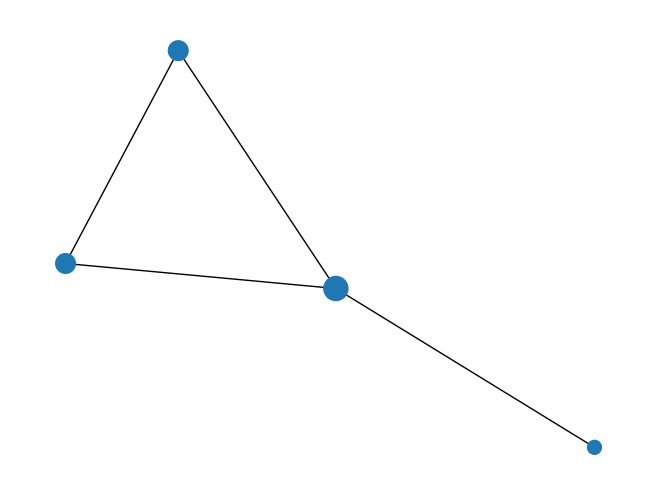

In [119]:
g = nx.Graph()
g.add_edges_from([(1,2), (2,3), (2,4), (3,4)])

d = dict(
g.degree
)

nx.draw(g, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
plt.show() 

In [121]:
G.degree

DiDegreeView({6957: 27, '91.546.000-3': 1, 7436: 1, '76.666.950-6': 1, '83.002.400-k': 2, '96.945.670-2': 2, 7248: 15, '92.264.000-9': 1, 115284: 1, '76.452.633-3': 1, '88.597.500-3': 1, '96.519.830-k': 1, '76.103.677-7': 1, '76.175.092-5': 1, '96.670.640-6': 1, 220665: 1, '78.566.250-4': 1, 111870: 4, '78.477.490-2': 1, '76.027.413-5': 1, '90.844.000-5': 1, '91.871.000-0': 1, '82.496.800-4': 1, 7046: 5, '76.752.511-7': 1, '84.060.600-7': 1, 7324: 2, '96.981.250-9': 3, '80.447.400-5': 1, 84959: 1, '78.823.470-8': 1, 113812: 7, '92.475.000-6': 2, '78.715.990-7': 1, 113259: 1, '76.722.635-7': 1, '11.647.874-9': 1, '87.674.400-7': 1, '77.604.890-9': 1, 127036: 1, '76.193.361-2': 1, '77.872.090-6': 1, '77.160.971-6': 1, 7375: 1, '76.842.382-2': 1, '81.821.100-7': 1, '88.466.300-8': 1, '76.479.314-5': 1, 7421: 1, '79.568.850-1': 1, 117584: 1, '65.020.623-1': 1, 7241: 1, '76.009.460-9': 1, '76.084.945-6': 2, '65.375.760-3': 1, 6918: 1, '73.187.600-2': 1, '76.447.530-5': 1, '81.323.800-4': 1,

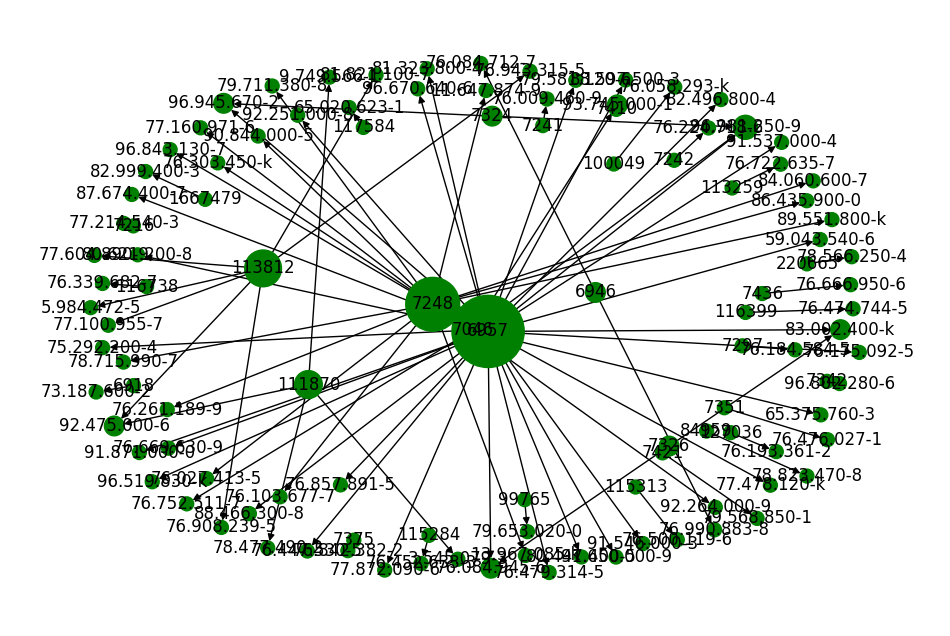

In [125]:
plt.figure(figsize=(12,8))
d = dict(G.degree)
nx.draw_networkx(G, pos=pos, node_color='green', node_size=[v * 100 for v in d.values()])
limits = plt.axis('off')

In [88]:
# G = nx.karate_club_graph()
best_partition, Q = fast_greedy(G)
print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(best_partition), "" if len(best_partition) == 1 else "es"))
for c in best_partition:
    print(c)
print("La modularidad de esta particion es:", Q)

La mejor partición encontrada consiste en 31 comunidades:
('76.666.950-6', 7436)
('78.823.470-8', 84959)
('76.452.633-3', 115284)
(220665, '78.566.250-4')
('76.474.744-5', 116399)
(7242, '76.224.718-6')
('82.999.400-3', 1667479)
(115313, '76.500.119-6')
('96.802.280-6', 7342)
(113259, '76.722.635-7')
(7297, '76.184.584-5')
(99765, '79.653.020-0')
('76.058.293-k', 100049)
('76.476.027-1', 7351)
(7216, '77.214.540-3')
(116738, '76.339.682-7')
(127036, '76.193.361-2')
('79.568.850-1', 7421)
(7241, '76.009.460-9')
('73.187.600-2', 6918)
(117584, '65.020.623-1')
('76.842.382-2', 7375)
('93.745.000-1', 7410)
('76.990.883-8', '76.084.712-7', 6946)
('75.292.200-4', '65.375.760-3', '76.752.511-7', 7046)
('76.084.945-6', 7326, '83.002.400-k')
('96.981.250-9', '96.945.670-2', 7324)
('81.821.100-7', 113812, '77.604.890-9', '77.100.955-7', '76.908.239-5', '5.984.472-5', '76.943.315-5')
('9.749.566-1', '92.475.000-6', '78.477.490-2', '3.545.079-3', 111870)
('90.844.000-5', '11.647.874-9', '89.551.80

In [105]:
i=0
colores = []
for c in best_partition:
    i+=1
    if len(c)>10:
        print(i)
        colores.append('red')
    else:
        colores.append('green')

    # print(f"Tamaño comunidad {i}: {len(c)}") 

30
31


[('76.666.950-6', 7436),
 ('78.823.470-8', 84959),
 ('76.452.633-3', 115284),
 (220665, '78.566.250-4'),
 ('76.474.744-5', 116399),
 (7242, '76.224.718-6'),
 ('82.999.400-3', 1667479),
 (115313, '76.500.119-6'),
 ('96.802.280-6', 7342),
 (113259, '76.722.635-7'),
 (7297, '76.184.584-5'),
 (99765, '79.653.020-0'),
 ('76.058.293-k', 100049),
 ('76.476.027-1', 7351),
 (7216, '77.214.540-3'),
 (116738, '76.339.682-7'),
 (127036, '76.193.361-2'),
 ('79.568.850-1', 7421),
 (7241, '76.009.460-9'),
 ('73.187.600-2', 6918),
 (117584, '65.020.623-1'),
 ('76.842.382-2', 7375),
 ('93.745.000-1', 7410),
 ('76.990.883-8', '76.084.712-7', 6946),
 ('75.292.200-4', '65.375.760-3', '76.752.511-7', 7046),
 ('76.084.945-6', 7326, '83.002.400-k'),
 ('96.981.250-9', '96.945.670-2', 7324),
 ('81.821.100-7',
  113812,
  '77.604.890-9',
  '77.100.955-7',
  '76.908.239-5',
  '5.984.472-5',
  '76.943.315-5'),
 ('9.749.566-1', '92.475.000-6', '78.477.490-2', '3.545.079-3', 111870),
 ('90.844.000-5',
  '11.647.874

In [104]:
colores

['white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'white',
 'green',
 'green']

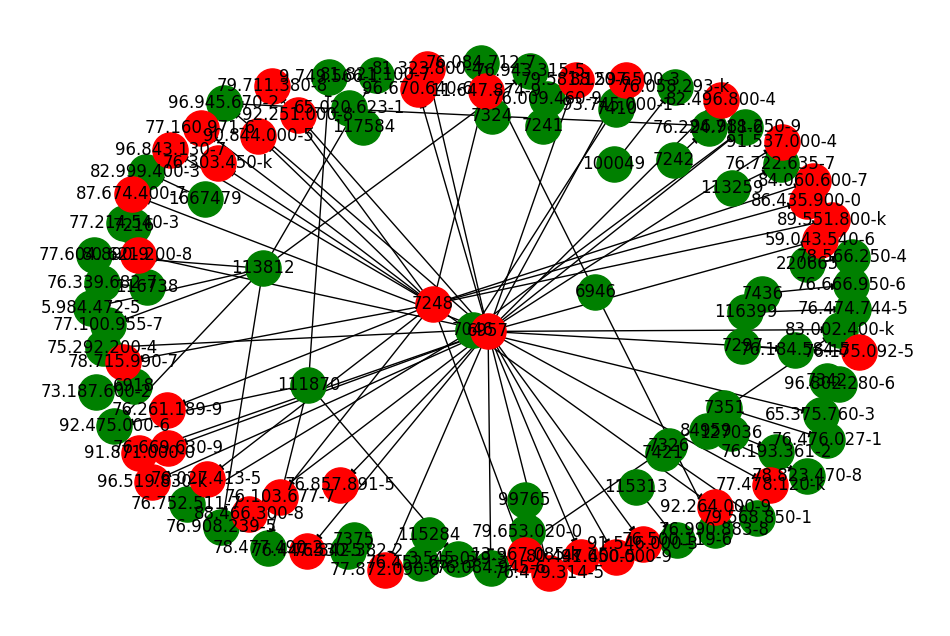

In [106]:
#  = best_partition

# colors = ['red', 'cyan','blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos)

for community, color in zip(best_partition, colores):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')

In [116]:
df_solo_3_empresas[df_solo_3_empresas['CodigoOrganismo']==7248]

,Codigo,Tipo de Adquisicion,Estado,CodigoOrganismo,NombreOrganismo,RutUnidad,ComunaUnidad,FechaPublicacion,CodigoProductoONU,RutProveedor,NombreProveedor,Moneda de la Oferta,MontoLineaAdjudica,Oferta seleccionada,Estado_numeric
8527,8628273,Licitación Pública MOP (O1),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Temuco,2020-01-07,101101001,99.589.100-K,BRÜNDL S.A.,Peso Chileno,0,No Seleccionada,0
8528,8628273,Licitación Pública MOP (O1),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Temuco,2020-01-07,101101001,99.537.890-6,Apia SPA,Peso Chileno,2394759946,Seleccionada,0
8626,8628453,Licitación Pública MOP (O1),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Temuco,2020-01-07,101101001,96.534.570-1,ABICE S.A.,Peso Chileno,0,No Seleccionada,0
8627,8628453,Licitación Pública MOP (O1),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Temuco,2020-01-07,101101001,76.565.099-2,Constructora Poo Limitada,Peso Chileno,1978068926,Seleccionada,0
10099,8630254,Licitación Pública MOP (O1),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Santiago Centro,2020-01-03,101101001,89.812.100-3,BROTEC CONSTRUCCION SPA,Peso Chileno,0,No Seleccionada,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878655,8740981,Licitación Pública Mayor 1000 UTM (LP),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Lebu,2020-09-25,51182401,76.075.434-k,Bretti Robert,Peso Chileno,0,No Seleccionada,0
1878656,8740981,Licitación Pública Mayor 1000 UTM (LP),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Lebu,2020-09-25,51182401,76.149.673-5,Felipe Andres,Peso Chileno,0,No Seleccionada,0
1878657,8740987,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Lebu,2020-09-25,51182401,76.305.289-3,Marini Ltda.,Peso Chileno,1,Seleccionada,0
1878658,8740987,Licitación Pública entre a 2000 y 5000 UTM (LQ),Adjudicada,7248,MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...,61.202.000-0,Lebu,2020-09-25,51182401,76.075.434-k,Bretti Robert,Peso Chileno,0,No Seleccionada,0


In [ ]:
# import community

# partition = community_louvain.best_partition(g)
# pos = nx.spring_layout(g)
# color=colores(partition.values())
# nx.draw_networkx_edges(g, pos=pos)
# nx.draw_networkx_nodes(g, pos=pos, node_color=color, node_size=800)
# nx.draw_networkx_labels(g, pos=pos)

In [ ]:

def colores(lista):
    colors = []
    for c in lista:
        if c==0:
            colors.append("red")
        elif c==1:
            colors.append("blue")
        elif c==2:
            colors.append("yellow")
        else:
            colors.append("green")
    return colors 

AttributeError: 'bool' object has no attribute 'items'

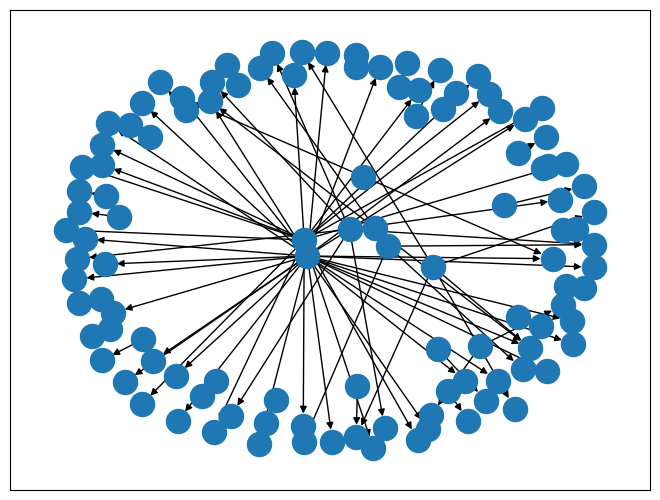

In [83]:
nx.draw(G,labels=True)